In [50]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Help Function

In [3]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #对naping矩阵进行转置，即将（0,1,2）转置为（1,2,0）
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

# Base Setting

In [4]:
class Config():
    #存放原始图像数据的文件路径
    training_dir = "C:/Users/liu/Desktop/Dataset of Siamese Network/training/"
    testing_dir = "C:/Users/liu/Desktop/Dataset of Siamese Network/testing/"
    train_batch_size = 64
    train_number_epochs = 100

# 建立数据预处理和提出正反样本数据

In [5]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        #数据集
        self.imageFolderDataset = imageFolderDataset
        #transform 图像预处理的方法
        self.transform = transform
        #是否转化为反色图像
        self.should_invert = should_invert
        
        
    #从原始数据中筛选出正反样本配对的sample
    def __getitem__(self,index):
        #
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #使用0到1之间的随机整数来实现50%的sample为相同target的图片
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #循环找到两张相同target的图片
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #循环找到两张不同target的图片
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        #convert()函数为图片格式的转化，有九种格式L，P，RGB，RGBA，CMYK，YCbCr,I，F ，其中L指的是灰度图片
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        #返回两张图片及其配对的target，一致为0，不一致为1
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [6]:
#加载数据
folder_dataset = dset.ImageFolder(root=Config.training_dir)
#对原始数据进行预处理和提取
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

# 搭建Siamese Network

In [7]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        #CNN
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            #in = 1*102*102，out = 4*100*100
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            #in = 4*102*102，out = 8*100*100
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            #in = 4*102*102，out = 8*100*100
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )
        #Full Connection Layer
        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        #change 1*8*100*100 to 1*80000
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

# Contrasive Loss

$L = \dfrac{1}{N}\sum_{1}^{N}yd^2+(1-y)\max(marge-d,0)^2$

In [8]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)#
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive


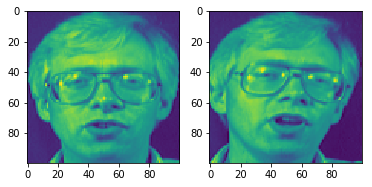

In [43]:
#target相同的sample
for i in siamese_dataset:
    if i[2]==0:
        plt.subplot(1,2,1)
        plt.imshow(i[0].numpy().reshape(100,100))
        plt.subplot(1,2,2)
        plt.imshow(i[1].numpy().reshape(100,100))
        break

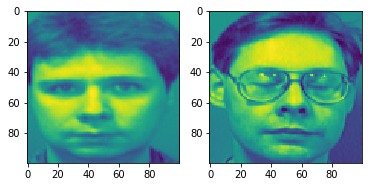

In [44]:
#target不同的sample
for i in siamese_dataset:
    if i[2]==1:
        plt.subplot(1,2,1)
        plt.imshow(i[0].numpy().reshape(100,100))
        plt.subplot(1,2,2)
        plt.imshow(i[1].numpy().reshape(100,100))
        break

# 开始训练

In [45]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        #num_workers=8,多线程可根据电脑情况开启或关闭
                        batch_size=Config.train_batch_size
                             #定义batch的大小)

In [47]:
net = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [48]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.6351728439331055

Epoch number 1
 Current loss 1.2772037982940674

Epoch number 2
 Current loss 1.2152292728424072

Epoch number 3
 Current loss 1.1997358798980713

Epoch number 4
 Current loss 1.225647211074829

Epoch number 5
 Current loss 1.239712119102478

Epoch number 6
 Current loss 1.123412847518921

Epoch number 7
 Current loss 1.2529759407043457

Epoch number 8
 Current loss 1.218011498451233

Epoch number 9
 Current loss 1.1936568021774292

Epoch number 10
 Current loss 1.1858396530151367

Epoch number 11
 Current loss 1.1961135864257812

Epoch number 12
 Current loss 1.2041375637054443

Epoch number 13
 Current loss 1.1001085042953491

Epoch number 14
 Current loss 1.1509342193603516

Epoch number 15
 Current loss 1.2086429595947266

Epoch number 16
 Current loss 1.1244547367095947

Epoch number 17
 Current loss 0.9794756174087524

Epoch number 18
 Current loss 1.142381191253662

Epoch number 19
 Current loss 1.1580623388290405

Epoch number 20

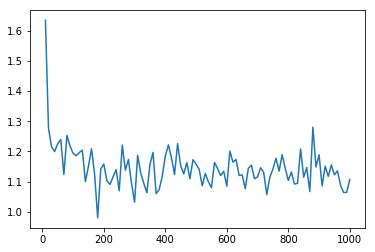

In [51]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        optimizer.zero_grad()
        #前项传播
        output1,output2 = net.forward(img0,img1)
        #计算损失函数
        loss_contrastive = criterion(output1,output2,label)
        #反向传播
        loss_contrastive.backward()
        #Adam优化
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)